In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
%matplotlib inline
import tensorflow as tf
import keras
import glob
import cv2
import pickle, datetime

from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import LSTM, Input,Activation

from keras.optimizers import RMSprop, SGD, Adam 
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing import sequence
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import load_model

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Import the backend
from keras import backend as K

import os

Using TensorFlow backend.


# Loading Images

In [2]:
img_dir='DS'
train_body_images = []
train_body_labels = [] 

for img_path in glob.glob(os.path.join(img_dir,'*.jpeg')):

    body_label = img_path.split("\\")[-1]

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_body_images.append(img)
    train_body_labels.append(body_label[0:body_label.find('#')])
train_body_images = np.array(train_body_images)
train_body_labels = np.array(train_body_labels)

# Preprocessing

In [3]:
label_to_num = {v:i for i,v in enumerate(np.unique(train_body_labels))}
num_to_label = {v: k for k, v in label_to_num.items()}

In [4]:
num_to_label

{0: 'Abdomen_CT Sample', 1: 'Chest_CT Sample', 2: 'Head_CT Sample'}

In [5]:
train_label_num = np.array([label_to_num[x] for x in train_body_labels])

In [6]:
train_body_images.shape, train_label_num.shape, train_body_labels.shape

((1500, 32, 32, 3), (1500,), (1500,))

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(train_body_images, train_label_num, test_size = 0.2, shuffle=True, random_state=2)

In [8]:
n_class=len(label_to_num)

In [9]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, n_class)

(1200, 32, 32, 3) (1200,) (300, 32, 32, 3) (300,) 3


In [10]:
#Normalization of the images and one-hot encoding of the labels

x_train_normalized = np.array(x_train / 255.0 - 0.5 )
x_test_normalized = np.array(x_test / 255.0 - 0.5 )

label_binarizer = LabelBinarizer()
y_train_hot = label_binarizer.fit_transform(y_train)
y_test_hot = label_binarizer.fit_transform(y_test)

# CNN Model

In [11]:
def cnn_model(input_shape,nb_classes):
    
    model = Sequential() 
    model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))


    model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1024, init='glorot_normal')) 
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 

    model.add(Dense(1024, init='glorot_normal')) 
    model.add(Activation('relu'))
    model.add(Dropout(0.5))


    model.add(Dense(nb_classes, init='glorot_normal')) 
    model.add(Activation('tanh'))

    return model

In [12]:
cnn_model = cnn_model((32,32,3),n_class)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 256)        

<ipython-input-11-29bbb073e0ae>:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="glorot_normal")`
  model.add(Dense(1024, init='glorot_normal'))
<ipython-input-11-29bbb073e0ae>:27: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="glorot_normal")`
  model.add(Dense(1024, init='glorot_normal'))
<ipython-input-11-29bbb073e0ae>:32: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="glorot_normal")`
  model.add(Dense(nb_classes, init='glorot_normal'))


In [13]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [14]:
#Training the CNN model with the normalized image data and labels
cnn_model.fit(x_train_normalized, y_train_hot, batch_size=15, epochs=5,verbose=1, validation_data=[x_test_normalized,y_test_hot])

Train on 1200 samples, validate on 300 samples
Epoch 1/5
1200/1200 [==============================] - 16s 13ms/step - loss: 8.9995 - accuracy: 0.3292 - val_loss: 10.5305 - val_accuracy: 0.3600
Epoch 2/5
1200/1200 [==============================] - 16s 13ms/step - loss: 9.6709 - accuracy: 0.3267 - val_loss: 5.9100 - val_accuracy: 0.3633
Epoch 3/5
1200/1200 [==============================] - 17s 14ms/step - loss: 9.5365 - accuracy: 0.3250 - val_loss: 5.8025 - val_accuracy: 0.3600
Epoch 4/5
1200/1200 [==============================] - 16s 13ms/step - loss: 9.9664 - accuracy: 0.3258 - val_loss: 5.8025 - val_accuracy: 0.3633
Epoch 5/5
1200/1200 [==============================] - 15s 13ms/step - loss: 9.6037 - accuracy: 0.3242 - val_loss: 5.8025 - val_accuracy: 0.3600


In [15]:
layer_name = 'dense_1'
FC_layer_model = Model(inputs=cnn_model.input,
                                 outputs=cnn_model.get_layer(layer_name).output)

# Feature Extraction

In [16]:
i=0
features=np.zeros(shape=(1500,1024))

for img_path in glob.glob(os.path.join(img_dir,'*.jpeg')):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)    
    img = cv2.resize(img, (32, 32))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img, axis=0)
    FC_output = FC_layer_model.predict(img)
    features[i]=FC_output
    i+=1
    if i==1500:
        break

In [17]:
len(features)

1500

In [18]:
feature_names=[]
for i in range(1024):
    feature_names.append("col_"+str(i))
    i+=1

In [19]:
#Create DataFrame with features and coloumn name
train_features=pd.DataFrame(data=features,columns=feature_names)
feature_names = np.array(feature_names)

In [20]:
train_features

,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_1014,col_1015,col_1016,col_1017,col_1018,col_1019,col_1020,col_1021,col_1022,col_1023
0,-222.507217,751.577698,-302.707916,-441.344757,-396.833282,-101.976181,-530.694702,-461.004242,-258.579742,375.487518,...,-340.363983,-63.819660,-416.149628,-236.072876,-61.185307,-214.990128,43.983704,411.510437,-437.762695,150.169067
1,-243.554398,869.131104,-349.803101,-507.908081,-439.861816,-124.647476,-607.029602,-533.003479,-305.682465,437.335724,...,-387.406311,-76.141579,-476.994904,-273.544739,-67.615631,-235.814499,55.247044,485.971741,-511.553009,170.470718
2,-200.793427,695.039734,-274.695679,-407.677673,-361.495605,-95.741394,-485.513916,-429.476929,-239.991592,346.556122,...,-314.518433,-56.168674,-382.356842,-214.582779,-58.734310,-198.571274,38.045200,380.940277,-401.793091,138.504562
3,-236.876678,803.319153,-321.407562,-471.175629,-419.262482,-107.459656,-565.037964,-490.751160,-275.357544,400.733948,...,-360.437958,-66.854065,-439.430939,-256.024811,-64.063179,-230.742432,48.923035,437.326447,-464.121521,162.618134
4,-242.037842,842.861755,-336.615967,-494.303864,-432.998535,-108.621239,-595.745850,-511.749023,-292.111786,413.527313,...,-374.639435,-69.745377,-466.247650,-263.598938,-70.010155,-234.953827,55.058327,455.282715,-488.815826,176.857941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,-261.438202,918.017273,-392.654144,-506.640289,-466.603882,-129.074631,-636.499634,-551.991150,-304.135193,442.627289,...,-397.621735,-107.445770,-507.996613,-319.212250,-64.955528,-264.614410,60.173847,503.918335,-548.462891,184.346237
1496,-245.841553,885.877197,-366.678223,-469.062256,-436.005524,-129.077393,-607.529236,-519.634583,-282.537750,421.249756,...,-363.412445,-92.306442,-475.679962,-312.884064,-47.641315,-262.374512,57.104500,485.987183,-515.789856,182.699860
1497,-235.628418,840.972778,-344.277740,-457.333862,-424.821716,-120.943634,-570.274475,-516.087036,-269.059509,406.972351,...,-348.657654,-92.241020,-454.943420,-296.447998,-58.577091,-236.166702,48.686623,457.817871,-489.652802,167.526703
1498,-222.359177,773.088135,-331.355988,-441.906464,-405.634155,-116.325630,-542.303406,-477.242279,-254.780838,380.254944,...,-340.856903,-89.519264,-427.004395,-268.408630,-58.897602,-230.799484,47.110676,429.254944,-463.466888,154.126038


In [21]:
from sklearn.model_selection import train_test_split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(train_features, train_label_num, test_size = 0.2, shuffle=True, random_state=2)

# KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train_1, y_train_1)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [23]:
y_pred = classifier.predict(x_test_1)

In [24]:
from sklearn.externals import joblib 
  
# Save the model as a pickle in a file 
joblib.dump(classifier, 'student-id-Knn.pkl')

c:\users\003560\appdata\local\programs\python\python38\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


['student-id-Knn.pkl']

In [25]:
#Evaluating Model
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_1, y_pred))
print(classification_report(y_test_1, y_pred))

[[ 90   0   0]
 [  1 107   0]
 [  0   0 102]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        90
           1       1.00      0.99      1.00       108
           2       1.00      1.00      1.00       102

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [26]:
accuracy=accuracy_score(y_test_1,y_pred)
print('KNN- Accuracy:', accuracy*100, '%.')

KNN- Accuracy: 99.66666666666667 %.


In [27]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train_1, y_train_1)
    pred_i = knn.predict(x_test_1)
    error.append(np.mean(pred_i != y_test_1))

Text(0, 0.5, 'Mean Error')

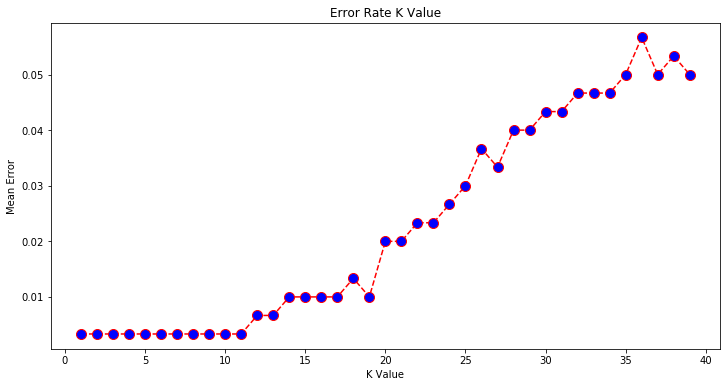

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

# Random Forest

In [29]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint

In [30]:
model_params={
# Number of trees in random forest
'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
# Number of features to consider at every split
'max_features' : ['auto', 'sqrt'],

# Minimum number of samples required to split a node
'min_samples_split' : [2, 5, 10],
# Minimum number of samples required at each leaf node
'min_samples_leaf' : [1, 2, 4] }

In [31]:
# creating random forest model
rf_model = RandomForestClassifier()

# consturct random search 
clf = RandomizedSearchCV(rf_model, model_params, n_iter=2, cv=3, random_state=1)

model = clf.fit(x_train_1, y_train_1)

# printing best set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1400,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [32]:
from sklearn.externals import joblib
  # Save the model as a pickle in a file
joblib.dump(model, 'student-id-Rf.pkl')

['student-id-Rf.pkl']

In [33]:
# predictions using the best-performing model
predictions = model.predict(x_test_1)

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test_1, predictions))
print(classification_report(y_test_1, predictions))

[[ 90   0   0]
 [  0 108   0]
 [  0   0 102]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        90
           1       1.00      1.00      1.00       108
           2       1.00      1.00      1.00       102

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



In [35]:
accuracy=accuracy_score(y_test_1,predictions)
print('RF- Accuracy:', accuracy*100, '%.')

RF- Accuracy: 100.0 %.
